In [1]:
import json, glob, os, sys
from itertools import groupby
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('..')
from imports import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
REVAL_DIR = os.path.expanduser('~/reval_50')
YLIM_AP = (0, 100)
YLIM_APL = (0, 60)
YLIM_F1 = (0, 1)
COLOR_SML = ['#00ff00', '#ffff00', '#ff0000']

In [2]:
files = glob.glob(f'{REVAL_DIR}/*/*/rich_results.json')
results = [load(f) for f in files]
gb = lambda it, key: groupby(sorted(it, key=key), key)

for key, group in gb(results, lambda x: x['model']):
    print(key, end=' ')

R101 R101_C4 R101_DC5 R101_FPN R50 R50_C4 R50_DC5 R50_FPN X101 

In [3]:
sum(int(r['elapsed']) for r in results)

1098273

In [4]:
def flatten(value):
    if 'results' not in results:
        return value
    result = value.copy()
    aps = {k: v for k, v in result['results']['bbox'].items() if '-' not in k}
    result.update(aps)
    del result['results']
    return result
# flatten(results[0])

In [5]:
c_df = pd.DataFrame([flatten(r) for r in results]).sort_values(['model', 'quality'])
c_df.tail()

,quality,model,elapsed,tp,fp,ex,precision,recall,f1,min_score,score_T,AP,AP50,AP75,APs,APm,APl
133,97,X101,2951.252516,24067,10415,2509,0.697958,0.662364,0.679696,0.500004,None,39.729067,57.164822,44.060526,22.527814,43.134439,52.148968
175,98,X101,2950.364302,24071,10454,2525,0.697205,0.662474,0.679396,0.500013,None,39.671298,56.972640,43.974836,22.536826,42.990778,52.161758
103,99,X101,2947.164570,24076,10449,2544,0.697350,0.662612,0.679537,0.500013,None,39.688723,57.002412,44.100901,22.536638,42.986291,52.165888
112,100,X101,2943.986512,24080,10452,2544,0.697324,0.662722,0.679583,0.500013,None,39.643490,56.998719,43.951267,22.560669,42.977207,52.128791
406,101,X101,2671.469082,24073,10472,2534,0.696859,0.662529,0.679261,0.500031,None,39.623151,56.986864,43.867873,22.578028,42.944338,52.106432


In [6]:
for mc in c_df.model.unique():
    ax = c_df[c_df.model == mc][['quality', 'AP', 'AP50', 'AP75']].plot(x='quality', ylim=YLIM_AP)
    ax.set_title(mc)
    save_plot(plt.gcf(), f"2021-03-01-Plot_reval_50_APs/01-APx-{mc}")
    plt.close() # prevent show

Figure saved to 2021-03-01-Plot_reval_50_APs/01-APx-R101.png and 2021-03-01-Plot_reval_50_APs/01-APx-R101.pdf
Figure saved to 2021-03-01-Plot_reval_50_APs/01-APx-R101_C4.png and 2021-03-01-Plot_reval_50_APs/01-APx-R101_C4.pdf
Figure saved to 2021-03-01-Plot_reval_50_APs/01-APx-R101_DC5.png and 2021-03-01-Plot_reval_50_APs/01-APx-R101_DC5.pdf
Figure saved to 2021-03-01-Plot_reval_50_APs/01-APx-R101_FPN.png and 2021-03-01-Plot_reval_50_APs/01-APx-R101_FPN.pdf
Figure saved to 2021-03-01-Plot_reval_50_APs/01-APx-R50.png and 2021-03-01-Plot_reval_50_APs/01-APx-R50.pdf
Figure saved to 2021-03-01-Plot_reval_50_APs/01-APx-R50_C4.png and 2021-03-01-Plot_reval_50_APs/01-APx-R50_C4.pdf
Figure saved to 2021-03-01-Plot_reval_50_APs/01-APx-R50_DC5.png and 2021-03-01-Plot_reval_50_APs/01-APx-R50_DC5.pdf
Figure saved to 2021-03-01-Plot_reval_50_APs/01-APx-R50_FPN.png and 2021-03-01-Plot_reval_50_APs/01-APx-R50_FPN.pdf
Figure saved to 2021-03-01-Plot_reval_50_APs/01-APx-X101.png and 2021-03-01-Plot_rev

In [7]:
avg_pivot = c_df.pivot_table(index='model', values=['AP', 'APl', 'APm', 'APs']).sort_values('AP', ascending=False)
avg_pivot

,AP,APl,APm,APs
model,,,,
X101,31.750981,43.047924,34.626094,16.179287
R101_C4,31.151578,44.985597,34.656815,13.820500
R101_DC5,30.974756,43.514956,34.482016,14.274992
R101_FPN,30.613107,42.431434,33.527600,15.062925
R50_DC5,29.505881,41.424220,32.880312,13.507232
R50_FPN,29.069423,40.293432,31.866892,14.003250
R50_C4,28.736655,41.974839,31.737248,12.488986
R101,26.555697,37.686844,29.477352,10.716540
R50,24.831616,36.097596,27.414568,9.573735


In [8]:
def _save_plot(plot, name='', title=None):
    if title:
        plot.set_title(title)
    fig = plot.get_figure()
    fig.set_size_inches(4, 4)
    if name:
        fig.savefig(name)

def plot_models(df, column, norm=False, **kwargs):
    avg_pivot = df.pivot_table(index='model', values=[column]).sort_values(column, ascending=False)
    c_pivot = df.pivot(index='quality', columns='model', values=column).reindex(columns=avg_pivot.index)
    title = f'{column}: all models'
    if norm:
        c_pivot = c_pivot / c_pivot.max(axis=0)
        title += ' (scaled)'
    ax = c_pivot.plot(**kwargs)
    ax.set_title(title)
    return ax


In [9]:
ax = plot_models(c_df, 'AP', ylim=None)
# _save_plot(ax, 'all_AP_raw.pdf')
save_plot(plt.gcf(), f"2021-03-01-Plot_reval_50_APs/02-all_AP_raw")
plt.close()

Figure saved to 2021-03-01-Plot_reval_50_APs/02-all_AP_raw.png and 2021-03-01-Plot_reval_50_APs/02-all_AP_raw.pdf


Figure saved to 2021-03-01-Plot_reval_50_APs/03-all_AP_scaled.png and 2021-03-01-Plot_reval_50_APs/03-all_AP_scaled.pdf


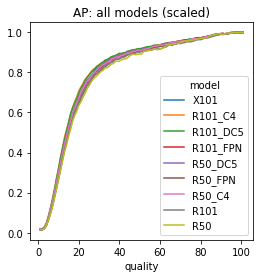

In [10]:
ax = plot_models(c_df, 'AP', True)
_save_plot(ax, 'all_AP_scaled.pdf')
save_plot(plt.gcf(), f"2021-03-01-Plot_reval_50_APs/03-all_AP_scaled")
plt.close()

In [11]:
for mc in c_df.model.unique():
    m_df = c_df[c_df.model == mc][['quality', 'APl', 'APm', 'APs']]
    ax = m_df.plot(x='quality', ylim=YLIM_APL, color=COLOR_SML)
    ax.set_title(mc)
    save_plot(plt.gcf(), f"2021-03-01-Plot_reval_50_APs/04-APsml-{mc}")
    plt.close()

Figure saved to 2021-03-01-Plot_reval_50_APs/04-APsml-R101.png and 2021-03-01-Plot_reval_50_APs/04-APsml-R101.pdf
Figure saved to 2021-03-01-Plot_reval_50_APs/04-APsml-R101_C4.png and 2021-03-01-Plot_reval_50_APs/04-APsml-R101_C4.pdf
Figure saved to 2021-03-01-Plot_reval_50_APs/04-APsml-R101_DC5.png and 2021-03-01-Plot_reval_50_APs/04-APsml-R101_DC5.pdf
Figure saved to 2021-03-01-Plot_reval_50_APs/04-APsml-R101_FPN.png and 2021-03-01-Plot_reval_50_APs/04-APsml-R101_FPN.pdf
Figure saved to 2021-03-01-Plot_reval_50_APs/04-APsml-R50.png and 2021-03-01-Plot_reval_50_APs/04-APsml-R50.pdf
Figure saved to 2021-03-01-Plot_reval_50_APs/04-APsml-R50_C4.png and 2021-03-01-Plot_reval_50_APs/04-APsml-R50_C4.pdf
Figure saved to 2021-03-01-Plot_reval_50_APs/04-APsml-R50_DC5.png and 2021-03-01-Plot_reval_50_APs/04-APsml-R50_DC5.pdf
Figure saved to 2021-03-01-Plot_reval_50_APs/04-APsml-R50_FPN.png and 2021-03-01-Plot_reval_50_APs/04-APsml-R50_FPN.pdf
Figure saved to 2021-03-01-Plot_reval_50_APs/04-APsm

In [12]:
# no color=COLOR_SML -- this plot is too bad anyway
pd.pivot(c_df, index='quality', columns='model', values=['APs', 'APm', 'APl']).plot(ylim=YLIM_APL);
save_plot(plt.gcf(), f"2021-03-01-Plot_reval_50_APs/05-APsml-all")
plt.close();

Figure saved to 2021-03-01-Plot_reval_50_APs/05-APsml-all.png and 2021-03-01-Plot_reval_50_APs/05-APsml-all.pdf


In [13]:
mAPsml = c_df.groupby('quality').agg({x: 'mean' for x in reversed(('APs', 'APm', 'APl'))})
mAPsml = mAPsml / mAPsml.max(axis=0)
plot = mAPsml.plot(color=COLOR_SML)
_save_plot(plot, 'average_APlms_scaled.pdf', 'Per-size AP (scaled)')
save_plot(plt.gcf(), f"2021-03-01-Plot_reval_50_APs/06-APsml-allavg-scaled")
plt.close()

Figure saved to 2021-03-01-Plot_reval_50_APs/06-APsml-allavg-scaled.png and 2021-03-01-Plot_reval_50_APs/06-APsml-allavg-scaled.pdf


In [14]:
plot = c_df.groupby('quality').agg({x: 'mean' for x in reversed(('APs', 'APm', 'APl'))}).plot(ylim=YLIM_AP, color=COLOR_SML)
_save_plot(plot, 'average_APlms.pdf', "Per-size AP (large, medium, small)")
save_plot(plt.gcf(), f"2021-03-01-Plot_reval_50_APs/07-APsml-allavg-raw")
plt.close()

Figure saved to 2021-03-01-Plot_reval_50_APs/07-APsml-allavg-raw.png and 2021-03-01-Plot_reval_50_APs/07-APsml-allavg-raw.pdf


# "Rich" results, with TPR, PPV and F1
Computed for Tc = 0.5, used to have wrong results (crowds, i.e. EX, counted as TP)

In [15]:
rich_files = glob.glob(f'{REVAL_DIR}/*/*/rich_results.json')

df = pd.DataFrame(load(f) for f in rich_files).sort_values(['model', 'quality'])
df.tail()

,quality,model,elapsed,tp,fp,ex,precision,recall,f1,min_score,score_T,AP,AP50,AP75,APs,APm,APl
133,97,X101,2951.252516,24067,10415,2509,0.697958,0.662364,0.679696,0.500004,None,39.729067,57.164822,44.060526,22.527814,43.134439,52.148968
175,98,X101,2950.364302,24071,10454,2525,0.697205,0.662474,0.679396,0.500013,None,39.671298,56.972640,43.974836,22.536826,42.990778,52.161758
103,99,X101,2947.164570,24076,10449,2544,0.697350,0.662612,0.679537,0.500013,None,39.688723,57.002412,44.100901,22.536638,42.986291,52.165888
112,100,X101,2943.986512,24080,10452,2544,0.697324,0.662722,0.679583,0.500013,None,39.643490,56.998719,43.951267,22.560669,42.977207,52.128791
406,101,X101,2671.469082,24073,10472,2534,0.696859,0.662529,0.679261,0.500031,None,39.623151,56.986864,43.867873,22.578028,42.944338,52.106432


In [16]:
for mc in df.model.unique():
    ax = df[df.model == mc][['quality', 'precision', 'recall', 'f1']].plot(x='quality', ylim=YLIM_F1)
    ax.set_title(mc)
    _save_plot(ax, f'{mc}_prf1.pdf')
    save_plot(plt.gcf(), f"2021-03-01-Plot_reval_50_APs/08-PRF1-{mc}")
    plt.close()

Figure saved to 2021-03-01-Plot_reval_50_APs/08-PRF1-R101.png and 2021-03-01-Plot_reval_50_APs/08-PRF1-R101.pdf
Figure saved to 2021-03-01-Plot_reval_50_APs/08-PRF1-R101_C4.png and 2021-03-01-Plot_reval_50_APs/08-PRF1-R101_C4.pdf
Figure saved to 2021-03-01-Plot_reval_50_APs/08-PRF1-R101_DC5.png and 2021-03-01-Plot_reval_50_APs/08-PRF1-R101_DC5.pdf
Figure saved to 2021-03-01-Plot_reval_50_APs/08-PRF1-R101_FPN.png and 2021-03-01-Plot_reval_50_APs/08-PRF1-R101_FPN.pdf
Figure saved to 2021-03-01-Plot_reval_50_APs/08-PRF1-R50.png and 2021-03-01-Plot_reval_50_APs/08-PRF1-R50.pdf
Figure saved to 2021-03-01-Plot_reval_50_APs/08-PRF1-R50_C4.png and 2021-03-01-Plot_reval_50_APs/08-PRF1-R50_C4.pdf
Figure saved to 2021-03-01-Plot_reval_50_APs/08-PRF1-R50_DC5.png and 2021-03-01-Plot_reval_50_APs/08-PRF1-R50_DC5.pdf
Figure saved to 2021-03-01-Plot_reval_50_APs/08-PRF1-R50_FPN.png and 2021-03-01-Plot_reval_50_APs/08-PRF1-R50_FPN.pdf
Figure saved to 2021-03-01-Plot_reval_50_APs/08-PRF1-X101.png and 20

In [17]:
ax = plot_models(df, 'precision', ylim=None)
_save_plot(ax, 'all_PPV_raw.pdf')
save_plot(plt.gcf(), f"2021-03-01-Plot_reval_50_APs/09-all_PPV_raw")
plt.close()

Figure saved to 2021-03-01-Plot_reval_50_APs/09-all_PPV_raw.png and 2021-03-01-Plot_reval_50_APs/09-all_PPV_raw.pdf


In [18]:
ax = plot_models(df, 'recall', ylim=YLIM_F1)
_save_plot(ax, 'all_TPR_raw.pdf')
save_plot(plt.gcf(), f"2021-03-01-Plot_reval_50_APs/10-all_TPR_raw")
plt.close()

Figure saved to 2021-03-01-Plot_reval_50_APs/10-all_TPR_raw.png and 2021-03-01-Plot_reval_50_APs/10-all_TPR_raw.pdf


In [19]:
ax = plot_models(df, 'f1') # ylim=YLIM_F1
_save_plot(ax, 'all_F1_raw.pdf')
save_plot(plt.gcf(), f"2021-03-01-Plot_reval_50_APs/11-all_F1_raw")
plt.close()

Figure saved to 2021-03-01-Plot_reval_50_APs/11-all_F1_raw.png and 2021-03-01-Plot_reval_50_APs/11-all_F1_raw.pdf


# Structural similarity (SSIM)

In [20]:
qdf = pd.read_csv('../data/val2017_means_per_Q.csv')
qdf.head(2)

,quality,mean_squared_error,peak_signal_noise_ratio,structural_similarity,filesize,B_per_kpx
0,1,536.18,21.205,0.539,7203.782,9.291
1,2,535.91,21.207,0.539,7207.225,9.295


In [21]:
avgdf = df.groupby('quality').agg('mean')
avgdf.tail(2)

,elapsed,tp,fp,ex,precision,recall,f1,min_score,AP,AP50,AP75,APs,APm,APl
quality,,,,,,,,,,,,,,
100,1167.795457,22732.222222,12496.888889,3080.555556,0.664482,0.625629,0.635651,0.500007,36.601524,53.349214,40.400493,18.416302,40.475657,50.006381
101,1090.967105,22744.333333,12510.444444,3084.888889,0.664255,0.625962,0.635728,0.500012,36.603540,53.371720,40.367561,18.458267,40.472502,50.037721


In [22]:
rich = pd.merge(avgdf, qdf, left_index=True, right_index=True)

In [23]:
ax = rich.plot(x='structural_similarity', y='recall', xlim=(0, 1), ylim=(0, 1))
_save_plot(ax, 'recall_by_ssim.pdf')
save_plot(plt.gcf(), f"2021-03-01-Plot_reval_50_APs/12-recall_by_ssim")
plt.close()

Figure saved to 2021-03-01-Plot_reval_50_APs/12-recall_by_ssim.png and 2021-03-01-Plot_reval_50_APs/12-recall_by_ssim.pdf


In [24]:
ax = rich.plot(x='structural_similarity', y='precision')#, xlim=(0, 1), ylim=(0, 1))
_save_plot(ax, '')
save_plot(plt.gcf(), f"2021-03-01-Plot_reval_50_APs/13-precision_by_ssim")
plt.close()

Figure saved to 2021-03-01-Plot_reval_50_APs/13-precision_by_ssim.png and 2021-03-01-Plot_reval_50_APs/13-precision_by_ssim.pdf


In [25]:
ax = rich.plot(x='structural_similarity', y='f1')#, xlim=(0, 1), ylim=(0, 1))
_save_plot(ax, '')
save_plot(plt.gcf(), f"2021-03-01-Plot_reval_50_APs/14-F1_by_ssim")
plt.close()

Figure saved to 2021-03-01-Plot_reval_50_APs/14-F1_by_ssim.png and 2021-03-01-Plot_reval_50_APs/14-F1_by_ssim.pdf


In [26]:
ax = rich.plot(x='quality', y='structural_similarity', ylim=(0, 1))
# , xlabel="jakość JPEG (Q)", ylabel="wartość SSIM", legend=False
_save_plot(ax, 'SSIM_by_q.pdf')
save_plot(plt.gcf(), f"2021-03-01-Plot_reval_50_APs/15-SSIM_by_quality")
plt.close()

Figure saved to 2021-03-01-Plot_reval_50_APs/15-SSIM_by_quality.png and 2021-03-01-Plot_reval_50_APs/15-SSIM_by_quality.pdf


In [27]:
ax = rich[['structural_similarity', 'precision', 'recall']].plot(x='structural_similarity', xlim=(0, 1), ylim=(0, 1))
_save_plot(ax, 'pr_by_SSIM.pdf')
save_plot(plt.gcf(), f"2021-03-01-Plot_reval_50_APs/16-pr_by_SSIM")
plt.close()

Figure saved to 2021-03-01-Plot_reval_50_APs/16-pr_by_SSIM.png and 2021-03-01-Plot_reval_50_APs/16-pr_by_SSIM.pdf


In [28]:
ax = rich.plot(x='quality', y='AP', ylim=(0, 100), xlim=(0, 100))
_save_plot(ax, '')
save_plot(plt.gcf(), f"2021-03-01-Plot_reval_50_APs/17-avgAP_by_quality")
plt.close()

Figure saved to 2021-03-01-Plot_reval_50_APs/17-avgAP_by_quality.png and 2021-03-01-Plot_reval_50_APs/17-avgAP_by_quality.pdf


In [29]:
ax = rich.plot(x='structural_similarity', y='AP', xlim=(0, 1), ylim=(0, 100))
_save_plot(ax, 'AP_by_SSIM.pdf')
save_plot(plt.gcf(), f"2021-03-01-Plot_reval_50_APs/18-avgAP_by_SSIM")
plt.close()

Figure saved to 2021-03-01-Plot_reval_50_APs/18-avgAP_by_SSIM.png and 2021-03-01-Plot_reval_50_APs/18-avgAP_by_SSIM.pdf


# Tables

In [30]:
rich.loc[[96, 90, 80, 60, 40, 20], ['AP', 'APl', 'APm', 'APs']].round(1).reset_index()

,index,AP,APl,APm,APs
0,96,36.6,49.9,40.4,18.4
1,90,36.3,49.9,40.1,18.1
2,80,35.5,49.3,39.1,17.1
3,60,34.1,47.9,37.5,15.5
4,40,32.2,46.0,35.5,14.0
5,20,24.5,36.1,27.2,9.8


In [31]:
rich['PPV'] = rich.precision * 100
rich['TPR'] = rich.recall * 100
rich['SSIM'] = rich.structural_similarity * 100
rich['size'] = rich.filesize / 1024
print(rich
     .replace('precision', 100 * rich.precision)
     .set_index('quality')
     .loc[
         [96, 90, 80, 60, 40, 20, 10],
         ['AP', 'AP50', 'AP75', 'APl', 'APm', 'APs', 'TPR', 'PPV', 'SSIM', 'size']
     ]
     #.reset_index()
     .round(1)
     .to_latex()
)

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &    AP &  AP50 &  AP75 &   APl &   APm &   APs &   TPR &   PPV &  SSIM &   size \\
quality &       &       &       &       &       &       &       &       &       &        \\
\midrule
96      &  36.5 &  53.3 &  40.3 &  49.9 &  40.4 &  18.3 &  62.5 &  66.5 &  99.9 &  167.1 \\
90      &  36.3 &  52.9 &  39.9 &  49.9 &  40.0 &  18.0 &  62.0 &  66.8 &  97.1 &  107.0 \\
80      &  35.5 &  51.9 &  39.0 &  49.2 &  39.0 &  17.0 &  60.8 &  67.2 &  93.4 &   74.6 \\
60      &  34.0 &  50.0 &  37.4 &  48.0 &  37.4 &  15.4 &  58.8 &  67.1 &  89.5 &   46.5 \\
40      &  32.1 &  47.6 &  35.1 &  46.0 &  35.4 &  14.0 &  56.5 &  66.7 &  86.3 &   33.9 \\
20      &  23.5 &  36.3 &  25.4 &  34.4 &  26.3 &   9.4 &  46.6 &  63.4 &  80.5 &   21.3 \\
10      &   8.8 &  14.4 &   9.2 &  12.9 &  10.1 &   3.4 &  22.7 &  54.3 &  72.6 &   13.5 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_30958/700065347.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  .to_latex()
